> This is a self-correcting activity generated by [nbgrader](https://nbgrader.readthedocs.io). Fill in any place that says `YOUR CODE HERE` or `YOUR ANSWER HERE`. Run subsequent cells to check your code.

---

# Generate handwritten digits with a VAE (PyTorch)

The goal here is to train a VAE to generate handwritten digits.

![VAE digits](images/vae_digits.png)

## Environment setup

In [1]:
import os
import math

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [2]:
# Setup plots
%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 8
%config InlineBackend.figure_format = 'retina'

In [3]:
import torch

print(f'PyTorch version: {torch.__version__}')
print("GPU found :)" if torch.cuda.is_available() else "No GPU :(")

import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

PyTorch version: 1.7.1+cpu
No GPU :(


## Data loading

In [4]:
# Load MNIST dataset
trainset = torchvision.datasets.MNIST(
    root="./data", train=True, transform=transforms.ToTensor(), download=True
)
testset = torchvision.datasets.MNIST(
    root="./data", train=False, transform=transforms.ToTensor(), download=True
)

0it [00:00, ?it/s]Downloading http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz to ./data/MNIST/raw/train-images-idx3-ubyte.gz
 98%|█████████▊| 9748480/9912422 [00:02<00:00, 3060871.59it/s]Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

0it [00:00, ?it/s]Downloading http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz to ./data/MNIST/raw/train-labels-idx1-ubyte.gz

  0%|          | 0/28881 [00:00<?, ?it/s]

0it [00:00, ?it/s]Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


  0%|          | 0/1648877 [00:00<?, ?it/s]

  3%|▎         | 49152/1648877 [00:00<00:13, 119686.56it/s]

 25%|██▌       | 417792/1648877 [00:00<00:07, 168586.21it/s]

 36%|███▌      | 589824/1648877 [00:01<00:04, 229940.63it/s]

 76%|███████▌  | 1245184/1648877 [00:01<00:01, 322222.14it/s]


0it [00:00, ?it/s]Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]Extracting ./data/MN

### Question

Create batch data loaders `trainloader` and `testloader` resp. for training and test datasets.

In [5]:
batch_size = 128

# YOUR CODE HERE
trainloader = torch.utils.data.DataLoader(dataset=trainset, batch_size=batch_size, shuffle=True)
testloader =  torch.utils.data.DataLoader(dataset=testset,  batch_size=batch_size, shuffle=True)

## Model definition

### Question

Complete the following class to create a variational autoencoder.

In [11]:
# VAE model
class VAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=20):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, latent_dim)
        self.fc3 = nn.Linear(hidden_dim, latent_dim)
        self.fc4 = nn.Linear(latent_dim, hidden_dim)
        self.fc5 = nn.Linear(hidden_dim, input_dim)
        
    def encode(self, x):
        """Encode input into its latent representation
        Returns mean and standard deviation"""
        
        h = F.relu(self.fc1(x))
        return self.fc2(h), self.fc3(h)
    
    def sample(self, mu, log_var):
        """Sample a random codings vector from a gaussian distribution
        Takes mean and log_var (gamma) as parameters"""
        
        std = torch.exp(log_var/2)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        """Decode codings"""
        
        h = F.relu(self.fc4(z))
        return torch.sigmoid(self.fc5(h))
    
    def forward(self, x):
        """Encode inputs to obtain mean and standard deviation
           Sample codings from gaussian distribution using mean and std
           Returns decoded codings, mean and standard deviation"""
        # YOUR CODE HERE
        mu, log_var = self.encode(x)
        z = self.sample(mu, log_var)
        return self.decode(z), mu, log_var

## Model training

### Question

Complete the following training loop to:
- instantiate the variational autoencoder on target device;
- instanciate the Adam optimizer;
- implement forward pass and gradient descent.

In [12]:
input_dim = 784
hidden_dim = 400
latent_dim = 20
num_epochs = 15
learning_rate = 1e-3
step_count = len(trainloader)
prints_per_epoch = 1  # Increase to see more feedback during training

# Instanciate VAE and optimizer
# YOUR CODE HERE
vae = VAE(input_dim, hidden_dim, latent_dim).to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=learning_rate)

# Train model
for epoch in range(num_epochs):
    for i, (x, _) in enumerate(trainloader):
        # Forward pass
        # YOUR CODE HERE
        x = x.to(device).view(-1, input_dim)
        x_reconst, mu, log_var = vae(x)

        # Compute reconstruction loss and KL divergence
        reconst_loss = F.binary_cross_entropy(x_reconst, x, reduction="sum")
        kl_div = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        loss = reconst_loss + kl_div

        # Backprop and optimize
        # YOUR CODE HERE
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print losses at regular intervals
        print_threshold = math.ceil(step_count / prints_per_epoch)
        if (i + 1) % print_threshold == 0 or (i + 1) == step_count:
            print(
                f"Epoch [{epoch + 1}/{num_epochs}]"
                f", step [{i + 1}/{step_count}]"
                f", reconst loss: {reconst_loss.item():.4f}"
                f", KL div: {kl_div.item():.4f}"
            )

Epoch [1/15], step [469/469], reconst loss: 10313.6328, KL div: 1931.9843
Epoch [2/15], step [469/469], reconst loss: 9139.3125, KL div: 2297.4756
Epoch [3/15], step [469/469], reconst loss: 8836.9746, KL div: 2362.1123
Epoch [4/15], step [469/469], reconst loss: 8405.8594, KL div: 2418.3159
Epoch [5/15], step [469/469], reconst loss: 8156.7822, KL div: 2344.6973
Epoch [6/15], step [469/469], reconst loss: 7933.8203, KL div: 2437.5803
Epoch [7/15], step [469/469], reconst loss: 7634.3564, KL div: 2398.5178
Epoch [8/15], step [469/469], reconst loss: 7791.7305, KL div: 2489.9961
Epoch [9/15], step [469/469], reconst loss: 7675.1680, KL div: 2437.4253
Epoch [10/15], step [469/469], reconst loss: 7858.2744, KL div: 2350.2769
Epoch [11/15], step [469/469], reconst loss: 8208.6699, KL div: 2463.6243
Epoch [12/15], step [469/469], reconst loss: 7806.6006, KL div: 2538.8896
Epoch [13/15], step [469/469], reconst loss: 7578.3091, KL div: 2514.4302
Epoch [14/15], step [469/469], reconst loss: 7

## Reconstructions visualization¶

In [13]:
def plot_image(image):
    # Convert PyTorch tensor to NumPy
    img_tensor = image.cpu().numpy() if torch.cuda.is_available() else image.numpy()
    plt.imshow(img_tensor.squeeze(), cmap="binary")
    plt.axis("off")

def show_reconstructions(model, images, n_images=8):
    """Show original and reconstructed images side-by-side"""
    
    inputs = images.reshape(-1, 28*28).to(device)
    reconstructions, _, _ = model(inputs)
    
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index].view(1, 28, 28))

### Question

Show reconstructions for one batch of test data.

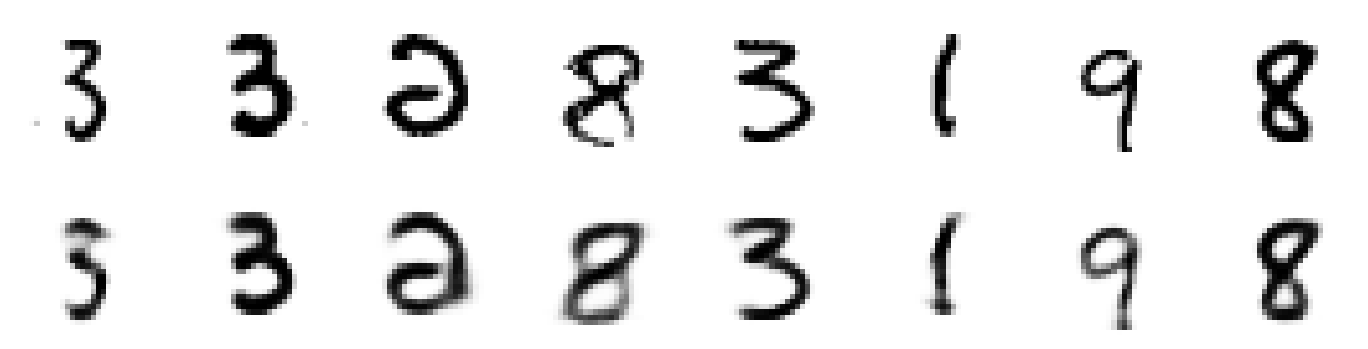

In [14]:
# YOUR CODE HERE
images, _ = iter(testloader).next()
with torch.no_grad():
    show_reconstructions(vae, images)

## Generating new images¶

In [15]:
def plot_multiple_images(images, n_cols=None):
    """Show a series of images"""

    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols * 1.5, 3))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plot_image(image)

### Question

Use the VAE to show several generated digits.

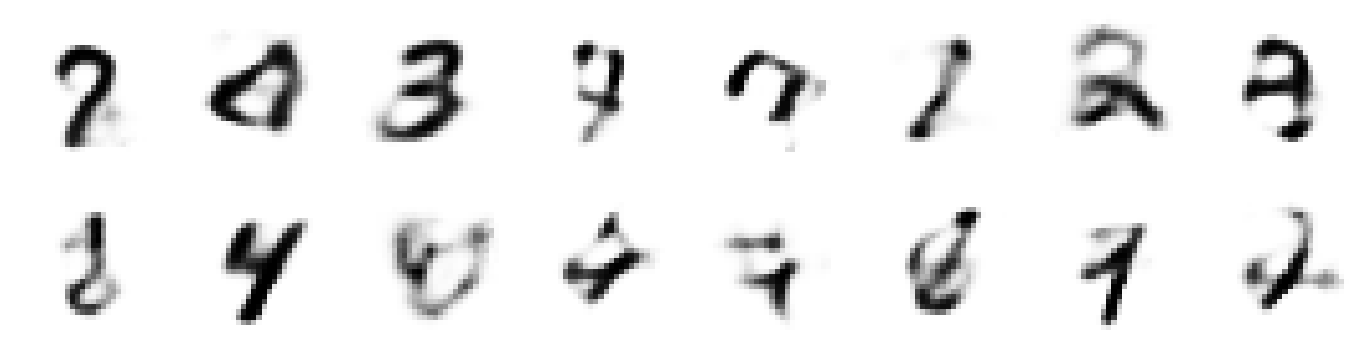

In [16]:
with torch.no_grad():
    z = torch.randn(16, latent_dim).to(device)
    # YOUR CODE HERE
    gen_images = vae.decode(z).view(-1, 1, 28, 28)
    plot_multiple_images(gen_images, n_cols=8)